# Offsite Test2

## 1. Read Data

In [2]:
from pyspark.sql import SparkSession
#from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import*
from pyspark.sql.types import*
from datetime import datetime as dt, timedelta
from pyspark.sql import Window

Ininialize spark session which run in local use 4 thread 

In [12]:
# Initialise spark session 
spark = SparkSession.builder.master('local[4]').getOrCreate()

In [13]:
#Set spark session timezone to UTC
spark.conf.set("spark.sql.session.timeZone", "UTC")

In [14]:
sqlContext = SQLContext(spark)

- Download the files from the link and rename to partx.parquet

In [15]:
# Read parquet file
df = sqlContext.read.parquet("part0.parquet","part1.parquet","part2.parquet","part3.parquet")

In [16]:
df.printSchema()

root
 |-- server_ts: long (nullable = true)
 |-- e_n: string (nullable = true)
 |-- uid: string (nullable = true)
 |-- device: string (nullable = true)



In [17]:
df.count()

1303198

In [642]:
df.show(5)

+-------------+------------------+--------+------+
|    server_ts|               e_n|     uid|device|
+-------------+------------------+--------+------+
|1526834759526|{"article_id":897}|d8ab96a3|mobile|
|1526834759498|{"article_id":288}|fcc4523f|mobile|
|1526834759837|{"article_id":342}|43268f68|mobile|
|1526834760073|{"article_id":970}|e66f2fd5|mobile|
|1526834760056|{"article_id":827}|aaabad9b|mobile|
+-------------+------------------+--------+------+
only showing top 5 rows



## 2. Transform Data 

In [18]:
# Extract article_id from json string
df2 = df.select('server_ts',json_tuple(df.e_n,'article_id').alias("article_id"),'uid','device')  

In [19]:
# Define convert_datetime function 
def convert_datetime(m_seconds) : 
    gmt_datetime=dt(1970, 1, 1) + timedelta(milliseconds= m_seconds)
    dtStr = gmt_datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")
    return dtStr

In [20]:
# Register convert_datetime function
dtfmt = udf(convert_datetime, StringType())

In [21]:
# Apply function
df3 = df2.withColumn('gmt_datetime', dtfmt(df2.server_ts))

In [22]:
df3.show(5)

+-------------+----------+--------+------+--------------------+
|    server_ts|article_id|     uid|device|        gmt_datetime|
+-------------+----------+--------+------+--------------------+
|1526834759526|       897|d8ab96a3|mobile|2018-05-20T16:45:...|
|1526834759498|       288|fcc4523f|mobile|2018-05-20T16:45:...|
|1526834759837|       342|43268f68|mobile|2018-05-20T16:45:...|
|1526834760073|       970|e66f2fd5|mobile|2018-05-20T16:46:...|
|1526834760056|       827|aaabad9b|mobile|2018-05-20T16:46:...|
+-------------+----------+--------+------+--------------------+
only showing top 5 rows



In [23]:
#Extract date and hour from gmt_datetime
df4 = df3.withColumn('view_date', date_format(df3.gmt_datetime.cast('timestamp'), 'yyyy-MM-dd').cast('date'))\
          .withColumn('view_hr', lpad(hour(df3.gmt_datetime),2,'0'))

In [24]:
#Check any date not in 2018-05-20
df4.filter(df4.view_date!='2018-05-20').count()

99

In [25]:
#View records 
df_check = df4.filter(df4.view_date!='2018-05-20')

In [26]:
df_check.head(5)

[Row(server_ts=1526860800241, article_id='815', uid='331c234a', device='mobile', gmt_datetime='2018-05-21T00:00:00.241000', view_date=datetime.date(2018, 5, 21), view_hr='00'),
 Row(server_ts=1526860800296, article_id='614', uid='388d7d18', device='mobile', gmt_datetime='2018-05-21T00:00:00.296000', view_date=datetime.date(2018, 5, 21), view_hr='00'),
 Row(server_ts=1526860800238, article_id='85', uid='b552d08a', device='mobile', gmt_datetime='2018-05-21T00:00:00.238000', view_date=datetime.date(2018, 5, 21), view_hr='00'),
 Row(server_ts=1526860800338, article_id='231', uid='d6e72fb9', device='mobile', gmt_datetime='2018-05-21T00:00:00.338000', view_date=datetime.date(2018, 5, 21), view_hr='00'),
 Row(server_ts=1526860800714, article_id='543', uid='a2857d03', device='mobile', gmt_datetime='2018-05-21T00:00:00.714000', view_date=datetime.date(2018, 5, 21), view_hr='00')]

In [27]:
#Filter records with date not in '2018-05-20'
df5 = df4.filter(df4.view_date =='2018-05-20')

# Q1 Page View Events Analysis

## Q1a The total number of pageviews

In [28]:
#Q1a Total pageviews
df5.count()

1303099

## Q1b The greatest view article

In [29]:
#Q1b The greatest view article
df5.groupBy("article_id").count().orderBy('count', ascending=False).show(1)

+----------+-----+
|article_id|count|
+----------+-----+
|       827|49243|
+----------+-----+
only showing top 1 row



## Q1c Greatest view article in each hour

In [30]:
#Check any invalid hour
df5.where((col("view_hr").isNull()) | (col("view_hr")>24)).show()

+---------+----------+---+------+------------+---------+-------+
|server_ts|article_id|uid|device|gmt_datetime|view_date|view_hr|
+---------+----------+---+------+------------+---------+-------+
+---------+----------+---+------+------------+---------+-------+



In [31]:
df_agg_hr = df5.groupBy("view_hr","article_id").count()

In [32]:
window = Window.partitionBy(df_agg_hr['view_hr']).orderBy(df_agg_hr['count'].desc())

In [33]:
df_1c = df_agg_hr.select('*', rank().over(window).alias('rank')) \
  .filter(col('rank') <= 1) 

In [34]:
df_1c.select(df_1c.view_hr.alias('hour') ,'article_id','count').orderBy('hour').show(24)

+----+----------+-----+
|hour|article_id|count|
+----+----------+-----+
|  00|       830| 3105|
|  01|       155| 4933|
|  02|       830| 2914|
|  03|       374| 5404|
|  04|       374| 6139|
|  05|       897| 4418|
|  06|       813| 3214|
|  07|       740| 2517|
|  08|       712| 3045|
|  09|       712| 1937|
|  10|       827| 6702|
|  11|       827| 7198|
|  12|       827| 6428|
|  13|       827| 5518|
|  14|       827| 4806|
|  15|        67| 6942|
|  16|       827| 3139|
|  17|       871| 2274|
|  18|       827| 1072|
|  19|       827|  696|
|  20|       827|  391|
|  21|       827|  430|
|  22|        85| 1636|
|  23|        85| 4229|
+----+----------+-----+



### Visualization on Q1c

In [35]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
#Visualization
df_pd = df_1c.toPandas()

In [37]:
df_pd_sort = df_pd.sort_values(by=['count'],ascending=False)

In [49]:
df_pd_sort.head()

,view_hr,article_id,count,rank
2,11,827,7198,1
1,15,67,6942,1
18,10,827,6702,1
19,12,827,6428,1
20,04,374,6139,1


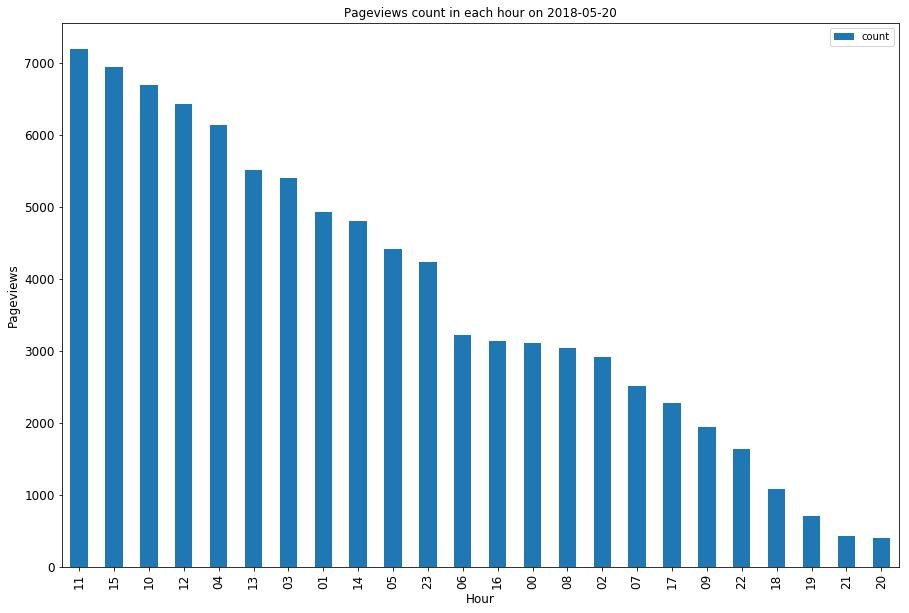

In [53]:
ax = df_pd_sort.plot(x='view_hr', y='count', kind='bar', title ="Pageviews count in each hour on 2018-05-20", \
                figsize=(15,10),legend=True, fontsize=12)
ax.set_xlabel("Hour",fontsize=12)
ax.set_ylabel("Pageviews",fontsize=12)


- 10am-12noon and 3:00pm are top 4 pageviews period

## Q1d Average and Median number of pageviews per user

In [54]:
df_agg = df5.groupBy("uid").count()

In [55]:
#Average
df_agg.agg({"count": "avg"}).show()

+-----------------+
|       avg(count)|
+-----------------+
|2.399509086322364|
+-----------------+



In [56]:
#Median
df_agg.approxQuantile("count", [0.5], 0.25)

[39.0]

# Q2 User Session Analysis

In [57]:
df_q2 = df5.select("uid","article_id","server_ts","gmt_datetime")

In [58]:
#Create window partition by uid
w = Window.partitionBy("uid").orderBy("server_ts")

In [59]:
#Calculate time differences
df_q2 = df_q2.withColumn("time_diff",(df_q2.server_ts - lag(df_q2.server_ts, 1) \
    .over(w)
    .cast("bigint"))) 

In [60]:
#Fill null values with 0
df_q2 = df_q2.na.fill({'time_diff':0})  

In [61]:
#Declare milliseconds in 30 mins variable
SESSION_DURATION = 1800000

In [62]:
#Find temp group with time_diff > 30 mins
df_q2 = df_q2.withColumn("indicator", ((df_q2.time_diff > SESSION_DURATION) | (df_q2.time_diff==0 )).cast("int"))    

In [63]:
#Assign temp_grp with time_diff > 30 mins
df_q2 = df_q2.withColumn("temp_grp",sum(df_q2.indicator).over(w))

In [64]:
#Create window partition by uid and temp_grp
w2 = Window.partitionBy("uid","temp_grp").orderBy("server_ts")

In [65]:
#Calculate accumulate time in each temp_grp
df_q2 = df_q2.withColumn("accum_time",df_q2.server_ts - min(df_q2.server_ts).over(w2))

In [66]:
#Create a check column
df_q2 = df_q2.withColumn("session_check",(df_q2.accum_time/SESSION_DURATION).cast('int'))

In [67]:
df_q2 = df_q2.withColumn("indicator2", df_q2.session_check - lag(df_q2.session_check,1,0).over(w2))

In [68]:
df_q2 = df_q2.withColumn("session_id", sum(df_q2.indicator+df_q2.indicator2).over(w))

In [69]:
df_session = df_q2.groupBy("uid","session_id").agg( \
    min("gmt_datetime").alias("start_time"), \
    max("gmt_datetime").alias("end_time"), \
    (max("server_ts") - min("server_ts")).alias('session_length'), \
    count("*").alias("pageviews"))

In [91]:
windowval = (Window.partitionBy('uid','temp_grp').orderBy('server_ts') \
             .rangeBetween(Window.unboundedPreceding, 0)) 

In [92]:
df_w_cumsum = df_q2.withColumn('cum_sum', when ((sum('time_diff').over(windowval)) > 1800000, 0). \
                                   otherwise(sum('time_diff').over(windowval)))

In [93]:
df_w_cumsum.select("uid","server_ts","time_diff","indicator","indicator2","cum_sum").show()

+--------+-------------+---------+---------+----------+-------+
|     uid|    server_ts|time_diff|indicator|indicator2|cum_sum|
+--------+-------------+---------+---------+----------+-------+
|000cd7dd|1526799963986|        0|        1|         0|      0|
|000cd7dd|1526800253259|   289273|        0|         0| 289273|
|000cd7dd|1526800399991|   146732|        0|         0| 436005|
|000cd7dd|1526800509294|   109303|        0|         0| 545308|
|000cd7dd|1526800775351|   266057|        0|         0| 811365|
|004abcf8|1526835814516|        0|        1|         0|      0|
|00723ac0|1526838965828|        0|        1|         0|      0|
|0074550b|1526784998203|        0|        1|         0|      0|
|0074550b|1526785886410|   888207|        0|         0| 888207|
|0074550b|1526811692291| 25805881|        1|         0|      0|
|0074550b|1526819833093|  8140802|        1|         0|      0|
|0075fc8c|1526816844858|        0|        1|         0|      0|
|0075fc8c|1526816871037|    26179|      

In [70]:
df_session.show()

+--------+----------+--------------------+--------------------+--------------+---------+
|     uid|session_id|          start_time|            end_time|session_length|pageviews|
+--------+----------+--------------------+--------------------+--------------+---------+
|000cd7dd|         1|2018-05-20T07:06:...|2018-05-20T07:19:...|        811365|        5|
|004abcf8|         1|2018-05-20T17:03:...|2018-05-20T17:03:...|             0|        1|
|00723ac0|         1|2018-05-20T17:56:...|2018-05-20T17:56:...|             0|        1|
|0074550b|         1|2018-05-20T02:56:...|2018-05-20T03:11:...|        888207|        2|
|0074550b|         2|2018-05-20T10:21:...|2018-05-20T10:21:...|             0|        1|
|0074550b|         3|2018-05-20T12:37:...|2018-05-20T12:37:...|             0|        1|
|0075fc8c|         1|2018-05-20T11:47:...|2018-05-20T11:51:...|        229361|        5|
|00a345f2|         1|2018-05-20T10:12:...|2018-05-20T10:12:...|             0|        1|
|00cc9468|         1|

## Q2a Total number of sessions

In [71]:
df_session.select("uid","session_id").count()

775120

In [72]:
df_session.agg(countDistinct('uid')).show()

+-------------------+
|count(DISTINCT uid)|
+-------------------+
|             543068|
+-------------------+



## Q2b User with largest number of session

In [73]:
df_session.groupBy("uid").count().orderBy('count', ascending=False).show(1)

+--------+-----+
|     uid|count|
+--------+-----+
|c82275f3|   47|
+--------+-----+
only showing top 1 row



## Q2c Average and median of session length

In [74]:
#Average
df_session.agg({"session_length": "avg"}).show()

+-------------------+
|avg(session_length)|
+-------------------+
| 143198.72549024667|
+-------------------+



In [75]:
#Median
df_session.approxQuantile("session_length", [0.5], 0.25)

[1795923.0]